## `tf.data` ：数据集的构建与预处理 

### 数据集对象的建立 

`tf.data` 的核心是 `tf.data.Dataset` 类，提供了对数据集的高层封装。`tf.data.Dataset` 由一系列的可迭代访问的元素（element）组成，每个元素包含一个或多个张量。比如说，对于一个由图像组成的数据集，每个元素可以是一个形状为 `长×宽×通道数` 的图片张量，也可以是由图片张量和图片标签张量组成的元组（Tuple）。

最基础的建立 `tf.data.Dataset` 的方法是使用 `tf.data.Dataset.from_tensor_slices()` ，适用于数据量较小（能够整个装进内存）的情况。具体而言，如果我们的数据集中的所有元素通过张量的第 0 维，拼接成一个大的张量（例如，前节的 MNIST 数据集的训练集即为一个 `[60000, 28, 28, 1]` 的张量，表示了 60000 张 28*28 的单通道灰度图像），那么我们提供一个这样的张量或者第 0 维大小相同的多个张量作为输入，即可按张量的第 0 维展开来构建数据集，数据集的元素数量为张量第 0 位的大小。具体示例如下：

In [1]:
import tensorflow as tf
import numpy as np

X = tf.constant([2013, 2014, 2015, 2016, 2017])
Y = tf.constant([12000, 14000, 15000, 16500, 17500])

# 也可以使用NumPy数组，效果相同
# X = np.array([2013, 2014, 2015, 2016, 2017])
# Y = np.array([12000, 14000, 15000, 16500, 17500])

dataset = tf.data.Dataset.from_tensor_slices((X, Y))

for x, y in dataset:
    print(x.numpy(), y.numpy())

2013 12000
2014 14000
2015 15000
2016 16500
2017 17500


In [28]:
import matplotlib.pyplot as plt 

(train_data, train_label), (_, _) = tf.keras.datasets.mnist.load_data()
train_data = np.expand_dims(train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
mnist_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))

### 数据集对象的预处理 

`tf.data.Dataset` 类为我们提供了多种数据集预处理方法。最常用的如：

- `Dataset.map(f)` ：对数据集中的每个元素应用函数 `f` ，得到一个新的数据集（这部分往往结合 `tf.io` 进行读写和解码文件， `tf.image` 进行图像处理）；
- `Dataset.shuffle(buffer_size)` ：将数据集打乱（设定一个固定大小的缓冲区（Buffer），取出前 `buffer_size` 个元素放入，并从缓冲区中随机采样，采样后的数据用后续数据替换）；
- `Dataset.batch(batch_size)` ：将数据集分成批次，即对每 `batch_size` 个元素，使用 `tf.stack()` 在第 0 维合并，成为一个元素。
- `Dataset.prefetch()` ：预取出数据集中的若干个元素

除此以外，还有 `Dataset.repeat()` （重复数据集的元素）、 `Dataset.reduce()` （与 Map 相对的聚合操作）、 [``](https://tf.wiki/zh/basic/tools.html#id4)Dataset.take ()``（）等，可参考 [API 文档](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset) 进一步了解。

以下以 MNIST 数据集进行示例。

使用 `Dataset.map()` 将所有图片旋转 90 度：

`Dataset.shuffle()` 时缓冲区大小 `buffer_size` 的设置

`tf.data.Dataset` 作为一个针对大规模数据设计的迭代器，本身无法方便地获得自身元素的数量或随机访问元素。因此，为了高效且较为充分地打散数据集，需要一些特定的方法。`Dataset.shuffle()` 采取了以下方法：

- 设定一个固定大小为 `buffer_size` 的缓冲区（Buffer）；
- 初始化时，取出数据集中的前 `buffer_size` 个元素放入缓冲区；
- 每次需要从数据集中取元素时，即从缓冲区中随机采样一个元素并取出，然后从后续的元素中取出一个放回到之前被取出的位置，以维持缓冲区的大小。

因此，缓冲区的大小需要根据数据集的特性和数据排列顺序特点来进行合理的设置。比如：

- 当 `buffer_size` 设置为 1 时，其实等价于没有进行任何打散；
- 当数据集的标签顺序分布极为不均匀（例如二元分类时数据集前 N 个的标签为 0，后 N 个的标签为 1）时，较小的缓冲区大小会使得训练时取出的 Batch 数据很可能全为同一标签，从而影响训练效果。一般而言，数据集的顺序分布若较为随机，则缓冲区的大小可较小，否则则需要设置较大的缓冲区。

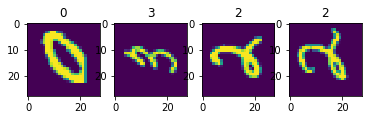

In [29]:
def rot90(image, label):
    image = tf.image.rot90(image)
    return image, label

mnist_dataset = mnist_dataset.map(rot90)

# 使用 Dataset.batch() 将数据集划分批次，每个批次的大小为 4
# 
mnist_dataset = mnist_dataset.shuffle(buffer_size=10000).batch(4)

i = 0
for images, labels in mnist_dataset:    # image: [4, 28, 28, 1], labels: [4]
    i += 1
    if i>1:break
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].set_title(labels.numpy()[i])
        axs[i].imshow(images.numpy()[i, :, :, 0])
    plt.show()

TensorFlow Datasets 提供了一个基于 `tf.data.Datasets` 的开箱即用的数据集集合，相关内容可参考 [TensorFlow Datasets](https://tf.wiki/zh/appendix/tfds.html) 。例如，使用以下语句：

In [ ]:
import tensorflow_datasets as tfds
dataset = tfds.load("mnist", split=tfds.Split.TRAIN)

TODO
tfds.load下载速度较慢

### 数据集元素的获取与使用 

构建好数据并预处理后，我们需要从其中迭代获取数据以用于训练。`tf.data.Dataset` 是一个 Python 的可迭代对象，因此可以使用 For 循环迭代获取数据，即：
```
dataset = tf.data.Dataset.from_tensor_slices((A, B, C, ...))
for a, b, c, ... in dataset:
    # 对张量a, b, c等进行操作，例如送入模型进行训练
```
也可以使用 `iter()` 显式创建一个 Python 迭代器并使用 `next()` 获取下一个元素，即：

```
dataset = tf.data.Dataset.from_tensor_slices((A, B, C, ...))
it = iter(dataset)
a_0, b_0, c_0, ... = next(it)
a_1, b_1, c_1, ... = next(it)
```

Keras 支持使用 `tf.data.Dataset` 直接作为输入。当调用 `tf.keras.Model` 的 `fit()` 和 `evaluate()` 方法时，可以将参数中的输入数据 `x` 指定为一个元素格式为 `(输入数据, 标签数据)` 的 `Dataset` ，并忽略掉参数中的标签数据 `y` 。例如，对于上述的 MNIST 数据集，常规的 Keras 训练方式是：
model.fit(x=train_data, y=train_label, epochs=num_epochs, batch_size=batch_size)
使用 `tf.data.Dataset` 后，我们可以直接传入 `Dataset` ：

```
model.fit(mnist_dataset, epochs=num_epochs)
```

由于已经通过 `Dataset.batch()` 方法划分了数据集的批次，所以这里也无需提供批次的大小。

### 实例：cats_vs_dogs 图像分类 

以下代码以猫狗图片二分类任务为示例，展示了使用 `tf.data` 结合 `tf.io` 和 `tf.image` 建立 `tf.data.Dataset` 数据集，并进行训练和测试的完整过程。数据集可至 [这里](https://www.floydhub.com/fastai/datasets/cats-vs-dogs) 下载。

In [ ]:
import tensorflow as tf
import os

num_epochs = 10
batch_size = 32
learning_rate = 0.001
data_dir = './datasets/cats_vs_dogs'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'
test_cats_dir = data_dir + '/valid/cats/'
test_dogs_dir = data_dir + '/valid/dogs/'

def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    image_resized = tf.image.resize(image_decoded, [256, 256]) / 255.0
    return image_resized, label

if __name__ == '__main__':
    # 构建训练数据集
    train_cat_filenames = tf.constant([train_cats_dir + filename for filename in os.listdir(train_cats_dir)])
    train_dog_filenames = tf.constant([train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)])
    train_filenames = tf.concat([train_cat_filenames, train_dog_filenames], axis=-1)
    train_labels = tf.concat([
        tf.zeros(train_cat_filenames.shape, dtype=tf.int32), 
        tf.ones(train_dog_filenames.shape, dtype=tf.int32)], 
        axis=-1)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
    train_dataset = train_dataset.map(_decode_and_resize)
    # 取出前buffer_size个数据放入buffer，并从其中随机采样，采样后的数据用后续数据替换
    train_dataset = train_dataset.shuffle(buffer_size=23000)    
    train_dataset = train_dataset.batch(batch_size)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(256, 256, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 5, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy]
    )

    model.fit(train_dataset, epochs=num_epochs)
    
 # 构建测试数据集
    test_cat_filenames = tf.constant([test_cats_dir + filename for filename in os.listdir(test_cats_dir)])
    test_dog_filenames = tf.constant([test_dogs_dir + filename for filename in os.listdir(test_dogs_dir)])
    test_filenames = tf.concat([test_cat_filenames, test_dog_filenames], axis=-1)
    test_labels = tf.concat([
        tf.zeros(test_cat_filenames.shape, dtype=tf.int32), 
        tf.ones(test_dog_filenames.shape, dtype=tf.int32)], 
        axis=-1)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
    test_dataset = test_dataset.map(_decode_and_resize)
    test_dataset = test_dataset.batch(batch_size)

    print(model.metrics_names)
    print(model.evaluate(test_dataset))